In [1]:
import numpy as np
import cv2 
%matplotlib inline
from matplotlib import pyplot as plt

# Helper Functions : 

### Test images utility

In [2]:
def create_sharp_img():
    
    ksize = 7
    
    test_img = np.zeros((ksize,ksize))
    #1-D to 3-D:
    test_img = np.dstack([test_img,test_img,test_img])

    test_img[1,1,0]= 1.0
    test_img[1,5,1]= 1.0
    test_img[ksize//2,ksize//2,:] = 1.0
    test_img[5,5,2] = 1.0
    test_img[5,1,1] = 1.0
    test_img[5,1,0] = 1.0
    
    
    #float to np.uint8
    test_img = test_img/np.max(test_img)
    test_img = test_img*255
    test_img = test_img.astype(np.uint8)

    
    return test_img



def create_gaussian_filter(ksize : np.uint16, sigma : np.float64):
    
    '''
    @function:
    Get 2-D Gaussian filter.
    
    @inputs:
    ksize: odd integer. Size of the output (symmetric) filter.
    sigma: standard deviation of the gaussian function used. (sigma_x= sigma_y)
    
    @output:
    gauss_f: symmetric gaussian filter,  of size = ksize, values ranging from 0 to 1 (value=1 only at the peak. the 0,0 point).
    
    @Notes:
    - In practice, you can get a gaussian kernel by applying gaussian blur to an 1-white-pixel image. This is equivalent 
    to the step response of the filter (same goes for any image filter that you have a function to calculate).
    
    - The Fourier Transform of the gaussian function is also a gaussian function of the same mean and variance.
    '''
    
    assert ksize%2 == 1, f'[Unexepcted Input]: ksize input must be an odd integer. {ksize} is not.'
    
    sample_points = np.arange(-np.floor(ksize/2),np.ceil(ksize/2),1) #points to sample the 1-D gaussian function at

    x , y = np.meshgrid(sample_points, sample_points)  #create a symmetric meshgrid (meshgrid from the same list)
    
    
    #Gaussian Function Parameters:
    mu_x = 0.0 #Keeps the center of the gaussian function at the (x = 0) point. 
               #Since x=0 is in the middle of our sample points (by design), then the peak of the gaussian function will be
                 #in the center of our output kernel. 
    mu_y = 0.0 #Keeps the center of the gaussian function at the (y = 0) point. 
    
    sigma_x = sigma #determines spread of the function over the x-axis (columns)
    sigma_y = sigma #determines spread of the function over the y-axis (rows)
    
    #Calculate Gaussian Kernel:
    gauss_f = np.exp(   -np.power(x - mu_x, 2.) / (2 * sigma_x**2)    + 
                        -np.power(y - mu_y, 2.) / (2 * sigma_y**2)      )
    
    return gauss_f 


def plot_3_imgs(img_list):
    fig = plt.figure(figsize=(20,10))

    plt.subplot(1, 3, 1)
    plt.imshow(img_list[0], cmap = 'gray')

    plt.subplot(1, 3, 2)
    plt.imshow(img_list[1])

    plt.subplot(1, 3, 3)
    plt.imshow(img_list[2])


    plt.show()


### Interpolation Utility

In [3]:
def FullCubicInterp(p: list, x:float):
    #Uses Catmull-Rom spline
    a_interp = -0.5*p[0]  +  1.5*p[1] -  1.5*p[2] + 0.5*p[3]
    b_interp = p[0] -  2.5*p[1] + 2*p[2] - 0.5*p[3]
    c_interp = -0.5*p[0]  + 0.5*p[2]
    d_interp = p[1]
    
    return a_interp*(x**3) + b_interp*(x**2) + c_interp*(x) + d_interp

# Source: * https://www.paulinternet.nl/?page=bicubic , beware, cubicInterpolate function is faulty, use the one here.

### Transformation Utility

In [4]:
def GetPixelValue(imArr: np.ndarray, posX: np.float64, posY: np.float64, method : str = 'CUBIC', verbose: bool = False):
    '''
    :function: Get the pixel value at the position given using the interpolation method given.
    NB: The output is rounded as an integer since this function works on images. So, the function will not work on float values.
    
    
    :param imArr: original image array, dtype must be np.uint8
    
    :param posX : X position of the point(dtype:float) needed. This is the X position of the T_inv(T(pixel[x])). Where T_inv and T are inverse
    transform and transform respectively.
    
    :param posY : Y position of the point(dtype:float) needed. This is the Y position of the T_inv(T(pixel[y])). Where T_inv and T are inverse
    transform and transform respectively.
    
    :param method : Type of interpolation method used.
    
    NB: T_inv(T(X)) != X due to rounding errors or due  to the fact that it may not be present (we are adding more pixels!)
    
    :return: value of pixel at T(pixel[x]),T(pixel[y])
    
    '''
    
    #Get integer and fractional parts of numbers 
        #(3- Make sure you account for edge cases (eg: negative indices, or indices that are outside the original source image))
    modXi = int(posX) #Shows x to the left of the point
    modYi = int(posY) #Show y above the point
    
    modXiPlusOneLim = min(modXi+1,imArr.shape[1]-1)
    modYiPlusOneLim = min(modYi+1,imArr.shape[0]-1)
    
    modXiMinusOneLim = max(modXi-1,0)
    modYiMinusOneLim = max(modYi-1,0)
    
    modXiPlusPlusOneLim = min(modXi+2,imArr.shape[1]-1)
    modYiPlusPlusOneLim = min(modYi+2,imArr.shape[0]-1)
    
    modXf = max(0 , posX - modXi)
    modYf = max(0 , posY - modYi)
    
    
    x_s = [modXi , modXiPlusOneLim]
    y_s = [modYi, modYiPlusOneLim]

    
    '''
        (modXi,modYi)-------------------(modXiPlusOneLim,modYi)
        |                                                |
        |                                                |
        |               (posX,posY)                      |
        |                                                |
        (modXi,modYiPlusOneLim)---------------------(modXiPlusOneLim,modYiPlusOneLim)
        
    '''
   
    
    
    if (method == "NEAREST"):

        nearest_x = sorted( x_s, key = lambda x: (x-posX)**2 ) [0] 
        nearest_y = sorted( y_s, key = lambda y: (y-posY)**2 ) [0]

        
        
        if (verbose): print(f' Of points : {points_list}\n. Point {(nearest_x,nearest_y)} is closest to {(posX, posY)}') 
        out = imArr[nearest_y,nearest_x,:]
        
    
    elif (method == "LINEAR"):
        out = []
        
        for chan in range(imArr.shape[2]):
            #print(chan)
            #print(imArr.shape)
            #Get surrouding four points:  #TODO 03

            bl = imArr[modYiPlusOneLim,modXi,chan] #bottom left
            br = imArr[modYiPlusOneLim,modXiPlusOneLim,chan] #bottom right
            
            tl = imArr[modYi,modXi,chan]  #top left
            tr = imArr[modYi,modXiPlusOneLim,chan] #top right
                
                
            #Line-Fitting  (visit: https://math.stackexchange.com/questions/2045174/how-to-find-a-point-between-two-points-with-given-distance)  
            
            #First Linear Fit: #TODO 04
            total_dist = abs(modXiPlusOneLim - modXi) #total distance between right and left pixels
            
            if total_dist: #if the total distance is not zero

                right_ratio = modXf/ total_dist #the contribution ratio of the right pixels 
                b = bl*(1-right_ratio) + br*right_ratio #Bottom Line point
                t = tl*(1-right_ratio) + tr*right_ratio #Top Line point
            else: #if zero assign to right pixels
                b = br 
                t = tr 
            
            #Second Linear Fit: #TODO 05
            total_y_dist = abs(modYiPlusOneLim - modYi) #total distance between top and bottom pixels
            
            if total_y_dist: #if the distance is not zero
                
                bottom_ratio = modYf/total_y_dist #contribution ratio of the bottom pixels
                pxf = t*(1-bottom_ratio) + b*bottom_ratio  #Actual Point
            
            else: #if zero assign to top pixels
                
                pxf = t 
            
            out.append(int(np.round(pxf)))

        
    elif (method == "CUBIC"):
        
        out = []
        
        for chan in range(imArr.shape[2]):
                

                #Get surrouding 16 points: 
                
                p = np.ndarray((4,4), dtype = np.float64)
                
                '''
                p[0,0] -- p[0,1] ------------ p[0,2] -- p[0,3]
                    |        |                   |        |
                p[1,0] -- p[1,1] ------------ p[1,2] -- p[1,3]
                    |        |    (posX,posY)   |         |
                p[2,0] -- p[2,1] ------------ p[2,2] -- p[2,3]
                    |        |                   |         |
                p[3,0] -- p[3,1] ------------ p[3,2] -- p[3,3]

                '''
                p[0,0]= imArr[ modYiMinusOneLim, modXiMinusOneLim, chan]
                p[0,1]= imArr[ modYiMinusOneLim, modXi, chan]
                p[0,2]= imArr[ modYiMinusOneLim, modXiPlusOneLim, chan]
                p[0,3]= imArr[ modYiMinusOneLim, modXiPlusPlusOneLim, chan]

                p[1,0]= imArr[ modYi, modXiMinusOneLim, chan]
                p[1,1]= imArr[ modYi, modXi, chan]
                p[1,2]= imArr[ modYi, modXiPlusOneLim, chan]
                p[1,3]= imArr[ modYi, modXiPlusPlusOneLim, chan]

                p[2,0]= imArr[ modYiPlusOneLim, modXiMinusOneLim, chan]
                p[2,1]= imArr[ modYiPlusOneLim, modXi, chan]
                p[2,2]= imArr[ modYiPlusOneLim, modXiPlusOneLim, chan]
                p[2,3]= imArr[ modYiPlusOneLim, modXiPlusPlusOneLim, chan]

                p[3,0]= imArr[ modYiPlusPlusOneLim, modXiMinusOneLim, chan]
                p[3,1]= imArr[ modYiPlusPlusOneLim, modXi, chan]
                p[3,2]= imArr[ modYiPlusPlusOneLim, modXiPlusOneLim, chan]
                p[3,3]= imArr[ modYiPlusPlusOneLim, modXiPlusPlusOneLim, chan]


                
                #First Cubic Fit:
                p_cubic = [0.0, 0.0, 0.0, 0.0]
                p_cubic[0] = FullCubicInterp(list(p[0,:]), modXf)
                p_cubic[1] = FullCubicInterp(list(p[1,:]), modXf)
                p_cubic[2] = FullCubicInterp(list(p[2,:]), modXf)
                p_cubic[3] = FullCubicInterp(list(p[3,:]), modXf)
                
                
                #Second Cubic Fit: #TODO 02
                point = FullCubicInterp(p_cubic,modYf)
                
                
                #Append this channel value:
                out.append( np.clip(int(np.round(point)), 0, 255) ) #Do we need to clip in the bilinear mode ? No. Why ?
            
            
            
    else:
        raise ValueError('UNKNOWN INTERPOLATION METHOD REQUESTED')
 
        
    
    return out

# Images to Test On:

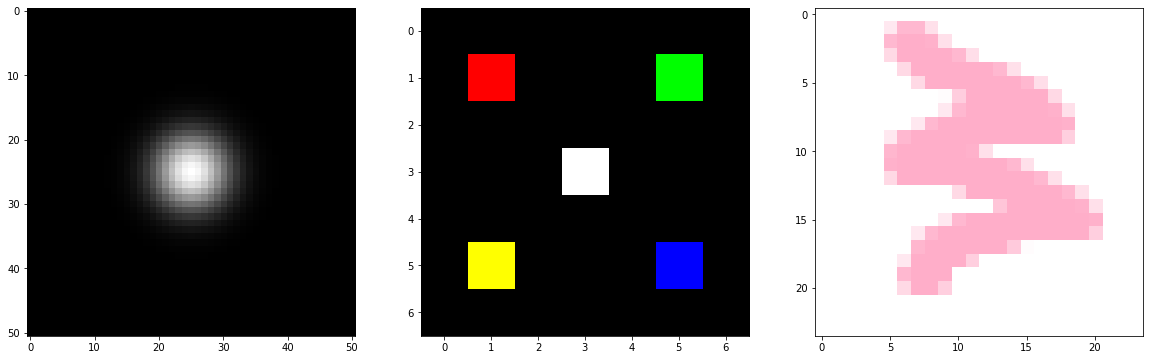

In [5]:
smooth_test_img    = create_gaussian_filter(ksize = 51, sigma= 4.0)
smooth_test_img  = ((smooth_test_img/np.max(smooth_test_img))*255).astype(np.uint8)
smooth_test_img = np.dstack([smooth_test_img,smooth_test_img,smooth_test_img])

sharp_test_img     = create_sharp_img()

character_test_img = cv2.imread('assets/Curve2.png')[:,:, ::-1] #[:,:, ::-1]  --> BGR to RGB


imgs_list = [smooth_test_img, sharp_test_img, character_test_img]

plot_3_imgs(imgs_list)

# OpenCV resize :

CUBIC


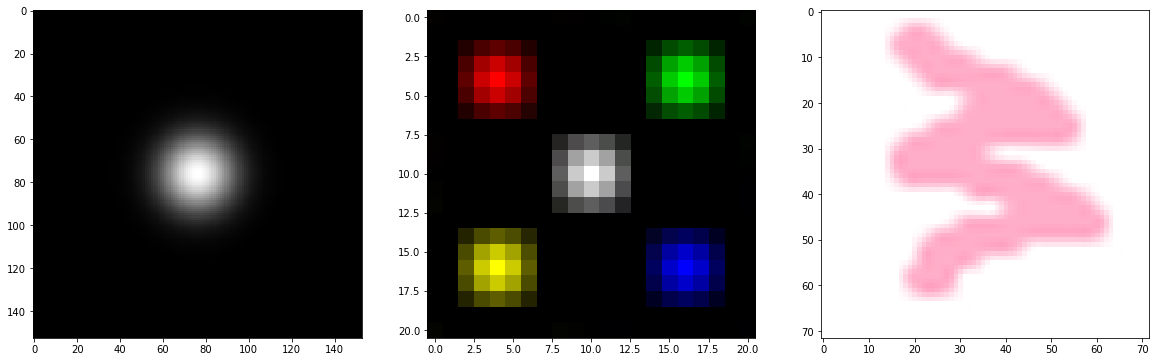

In [6]:
resize_ratio = 3.0
#Bicubic Interpolation:
#TODO 01 #Use Bicubic Interpolation, use the documentation link : 
    #https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html
cubic_resized_list = []
for test_img in imgs_list:
    resized = cv2.resize(test_img, 
                         (int(test_img.shape[1]*resize_ratio) ,int(test_img.shape[0]*resize_ratio)),
                         interpolation = cv2.INTER_CUBIC)
    cubic_resized_list.append(resized)
    
print('CUBIC')
plot_3_imgs(cubic_resized_list)

# Our Resize :

In [7]:
resize_ratio = 3.0

LINEAR


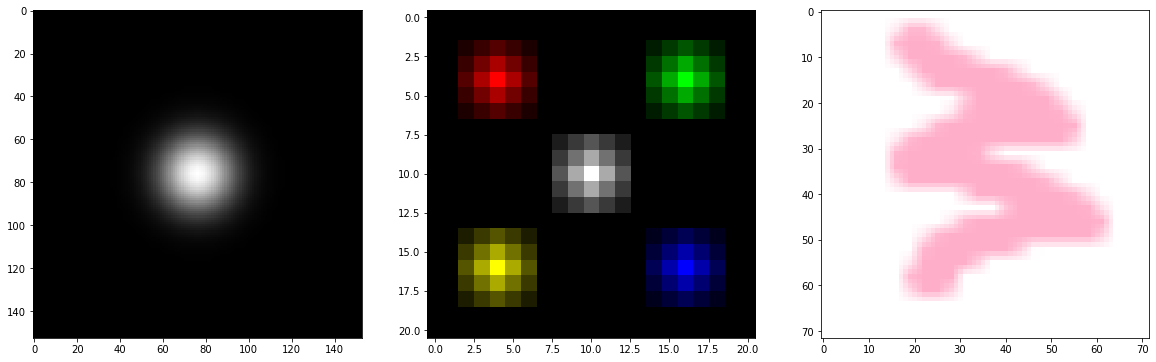

In [8]:
#Bilinear Interpolation:
my_linear_resized_list = []
for test_img in imgs_list:

    im  = test_img
    #1 : Calculate the size of the new image give the transformation
    enlargedShape = ( int(np.round(im.shape[0]*resize_ratio)),
                      int(np.round(im.shape[1]*resize_ratio)),
                      im.shape[2]
                    )
    enlargedImg = np.empty(enlargedShape, dtype=np.uint8)  #Empty new image


    #Calculate the inverse transform 
    #(Note here that the inverse transform is calculated from the actual size, not from 1/resize_ratio)
    rowScale = float(im.shape[0]) / float(enlargedImg.shape[0])
    colScale = float(im.shape[1]) / float(enlargedImg.shape[1])


    #2- Loop over pixels in the the new -now empty- image and assign them one by one by:
    for r in range(enlargedImg.shape[0]):
        for c in range(enlargedImg.shape[1]):

            #Applying inverse transformation to the pixel postions from the new image:
            #3- Make sure you account for edge cases (eg: negative indices, or indices that are outside the original source image)
            orir = (r-(1/rowScale)//2) * rowScale #(r-resize_ratio/2) * rowScale #Find original row in original image
            oric = (c-(1/colScale)//2) * colScale #(c-resize_ratio/2) * colScale

            #Interpolating value for the inverse(new_pixel_position) from surrounding pixels in source image
            enlargedImg[r, c] = GetPixelValue(im, oric, orir, method = "LINEAR", verbose = False)

    my_linear_resized_list.append(enlargedImg)

print('LINEAR')
plot_3_imgs(my_linear_resized_list)



CUBIC


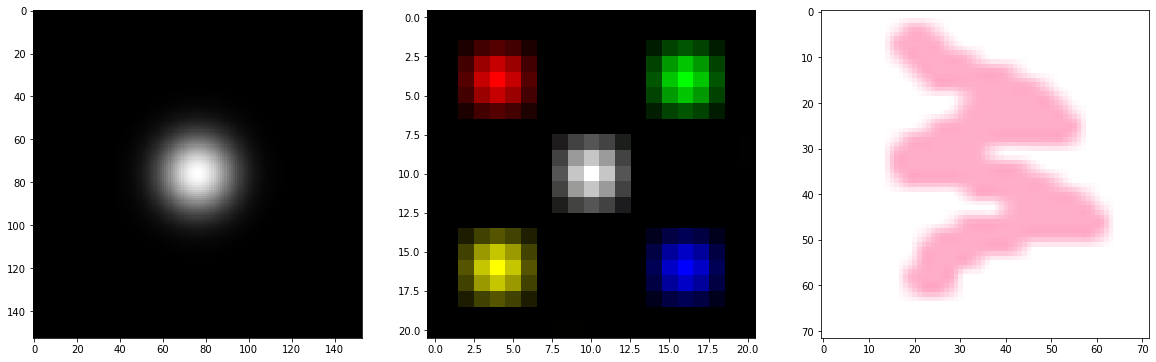

In [9]:
#Bicbuic Interpolation:
my_cubic_resized_list = []
for test_img in imgs_list:

    im  = test_img
    #1 : Calculate the size of the new image give the transformation
    enlargedShape = ( int(np.round(im.shape[0]*resize_ratio)),
                      int(np.round(im.shape[1]*resize_ratio)),
                      im.shape[2]
                    )
    enlargedImg = np.empty(enlargedShape, dtype=np.uint8)  #Empty new image


    #Calculate the inverse transform 
    #(Note here that the inverse transform is calculated from the actual size, not from 1/resize_ratio)
    rowScale = float(im.shape[0]) / float(enlargedImg.shape[0])
    colScale = float(im.shape[1]) / float(enlargedImg.shape[1])


    #2- Loop over pixels in the the new -now empty- image and assign them one by one by:
    for r in range(enlargedImg.shape[0]):
        for c in range(enlargedImg.shape[1]):

            #Applying inverse transformation to the pixel postions from the new image:
            #3- Make sure you account for edge cases (eg: negative indices, or indices that are outside the original source image)
            orir = (r-(1/rowScale)//2) * rowScale #(r-resize_ratio/2) * rowScale #Find original row in original image
            oric = (c-(1/colScale)//2) * colScale #(c-resize_ratio/2) * colScale

            #Interpolating value for the inverse(new_pixel_position) from surrounding pixels in source image
            enlargedImg[r, c] = GetPixelValue(im, oric, orir, method = "CUBIC", verbose = False)

    my_cubic_resized_list.append(enlargedImg)

print('CUBIC')
plot_3_imgs(my_cubic_resized_list)

